# Analyze and plot methods for hurricane forecast uncertainty
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria

## Python setup

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shash_tfp
from build_data import build_hurricane_data
import build_model
import model_diagnostics
from silence_tensorflow import silence_tensorflow
import prediction
from sklearn.neighbors import KernelDensity
import pandas as pd
from tqdm import tqdm
import analysis_plots
from scipy import stats
from toolbox import custom_round, ceiling_round
import seaborn as sns
from matplotlib import cm

import imp
import warnings
warnings.filterwarnings("ignore")
silence_tensorflow()
dpiFig = 400

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## User parameters

In [2]:
__author__  = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "03 June 2022"

EXP_NAME_LIST = (
                    "intensity302_EPCP48",    
                    # "intensity202_AL48",    
                )

PLOT_SEED_VECTOR = {
                    "intensity302_EPCP48": 739,
                    "intensity202_AL48": 416,    
                   }
TESTING_YEAR_VECTOR = {
                       "intensity302_EPCP48": 2020,
                       "intensity202_AL48": 2018,
                      }
                        
    

SHASH_INCS = np.arange(-160,161,1)
DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
FIGURE_PATH = "figures/paper_figures/"
PREDICTION_PATH = "saved_predictions/"

In [3]:
RI_THRESH_DICT = {24: 30,
                  48: 55,
                  72: 65,
                 }

## Plotting functions

In [4]:
FS = 16
colors = ('#D95980','#284E60','#284E60','#C3B1E1','#351F27','#A9C961')

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

In [5]:
def get_storm_details(df, isample):
    storm = df.iloc[isample]
    storm_name = storm['Name']
    storm_ftime = storm['ftime(hr)']
    storm_month = str(storm['time'])[:-4]
    storm_day = str(storm['time'])[-4:-2]
    storm_hour = str(storm['time'])[-2:]
    storm_year = storm['year']

    details = storm_name + ' ' + str(storm_year) + '-' + str(storm_month) + '-' + str(storm_day) + ' ' + str(storm_hour) + '00 @' + str(storm_ftime) + 'hr'
    
    return details

In [6]:
def plot_iqr_vs_error(ax,model, x_eval, onehot_eval, df_eval, yvar="shash_error"):
    # make predictions
    mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params(x_eval, model)    

    # convert y_pred to intensity corrections    
    ann_correction  = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.5)
    true_correction = df_eval['OBDV'].to_numpy()  

    # convert to full intensity predictions
    cons_intensity  = df_eval['VMXC'].to_numpy()
    ann_intensity   = cons_intensity + ann_correction
    true_intensity  = cons_intensity + true_correction

    # compute errors
    shash_error  = np.abs(ann_intensity - true_intensity)
    cons_error = np.abs(cons_intensity - true_intensity)

    # covert shash prediction bounds
    shash_low_correction  = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.25)
    shash_high_correction = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.75)
    iqr                   = shash_high_correction - shash_low_correction

    print(stats.spearmanr(iqr,shash_error))
    print(stats.pearsonr(iqr,shash_error))

    df_eval['iqr'] = iqr
    df_eval['shash_error'] = shash_error
    df_eval['cons_error'] = cons_error

    #------------------------------------------------------------------------------------
    ROUND_BASE = 10

    df_plot = df_eval.copy()
    df_plot['iqr'] = pd.Series(df_plot['iqr']).apply(lambda x: custom_round(x, base=ROUND_BASE))
    df_plot['iqr'] = pd.Series(df_plot['iqr']).apply(lambda x: ceiling_round(x, ceiling=30))
    #-----------------------------------------------------------------------------
    clr = colors[0]
    if(yvar=="cons_error"):
        clr =colors[1]
    
    for xvar in ('iqr',):#('sigma', 'range_66'):
        g = sns.boxplot(
            ax=ax,
            data=df_plot,
            x=xvar, y=yvar,
            whis=None,
            fliersize=0,
            boxprops={'alpha':.2,
                      'edgecolor': 'gray',
                      'color': 'gray',
                     },
        )      
        plt.setp(g.artists, edgecolor = '.4', facecolor='.95')
        plt.setp(g.lines, color='.4')
        ax = sns.stripplot(ax=ax,x=xvar, y=yvar, data=df_plot, color=clr, size=3.,alpha=.75,)
        # plt.axhline(y=0,color='k', alpha=.25, linewidth=1)

        # g.set_xlim(-.5,6.5)

        ax.set_xlabel('Predicted IQR [knots]')
        if(yvar=="cons_error"):
            ax.set_title('(b) Consensus Error vs SHASH Predicted Uncertainty', fontsize=FS*.9, color='k')    
            ax.set_ylabel('Absolute Error [knots]')
        else:
            ax.set_title('(a) SHASH Error vs SHASH Predicted Uncertainty', fontsize=FS*.9, color='k')            
            ax.set_ylabel('Absolute Error [knots]')        



## Network functions

In [7]:
def load_model():
    model_name = (
        exp_name + "_" + 
        str(TESTING_YEARS) + '_' +
        settings["uncertainty_type"] + '_' + 
        f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
    )
    pprint.pprint(model_name)
    
    if settings["uncertainty_type"] == "bnn":       
        model = build_model.build_bnn_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            act_fun=settings["act_fun"],
        )
        
    elif settings["uncertainty_type"] == "mcdrop":       
        model = build_model.build_mcdrop_model(
            x_train,
            onehot_train,
            dropout_rate=settings["dropout_rate"],                
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            act_fun=settings["act_fun"],
        )

    elif settings["uncertainty_type"][:5] == "shash": 
        model = build_model.build_shash_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        
    model.load_weights(MODEL_PATH + model_name + "_weights.h5")
        
    return model, model_name

In [8]:
def get_predictions(model, x_eval):
    runs = 5_000
    shash_cpd = np.zeros((np.shape(x_eval)[0],len(SHASH_INCS)))
    shash_med = np.zeros((np.shape(x_eval)[0],))
    mc_cpd = np.zeros((np.shape(x_eval)[0],runs))
    tf.random.set_seed(network_seed)

    if settings["uncertainty_type"] == "bnn":               
        for i in tqdm(range(0,runs)):
            mc_cpd[:,i] = np.reshape(model.predict(x_eval),np.shape(mc_cpd)[0])
        return mc_cpd, np.median(mc_cpd,axis=1)
    
    elif settings["uncertainty_type"] == "mcdrop":  
        # loop through runs for mcdrop calculation  
        for i in tqdm(range(0,runs)):
            mc_cpd[:,i] = np.reshape(model(x_eval,training=True),np.shape(mc_cpd)[0])    
        return mc_cpd, np.median(mc_cpd,axis=1)
    
    elif settings["uncertainty_type"][:5] == "shash": 
        # loop through samples for shash calculation and get PDF for each sample
        for j in tqdm(range(0,np.shape(shash_cpd)[0])):
            mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_eval[np.newaxis,j], model )
            dist = shash_tfp.Shash(mu_pred, sigma_pred, gamma_pred, tau_pred)
            
            shash_cpd[j,:] = dist.prob(SHASH_INCS)    
            shash_med[j]   = dist.median()
        return shash_cpd, shash_med
    
    else:
        raise NotImplementedError('no such uncertainty type')


## Load the models

In [9]:
pred_dict = {}
for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)

    TESTING_YEARS = TESTING_YEAR_VECTOR[exp_name]
    settings["years_test"] = (TESTING_YEARS,)
    
    RNG_SEED = PLOT_SEED_VECTOR[exp_name]
    settings['rng_seed'] = RNG_SEED
    seed_dict = {}
    
    NETWORK_SEED_LIST = [settings["rng_seed"]]
    network_seed = NETWORK_SEED_LIST[0]
    tf.random.set_seed(network_seed)  # This sets the global random seed.  

    # get the data
    (
        data_summary,        
        x_train,
        onehot_train,
        x_val,
        onehot_val,
        x_test,
        onehot_test,        
        x_valtest,
        onehot_valtest,
        df_train,
        df_val,
        df_test,
        df_valtest,
    ) = build_hurricane_data(DATA_PATH, settings, verbose=1)
    # x_eval, onehot_eval, df_eval = x_test, onehot_test, df_test

    # load the correct model
    model, model_name = load_model()

    # get predictions
    pred_test = get_predictions(model, x_test)
    pred_valtest = get_predictions(model, x_valtest)

    seed_dict[network_seed] = {'pred_cpd_test': pred_test[0], 
                               'pred_med_test': pred_test[1],
                               'pred_cpd_valtest': pred_valtest[0], 
                               'pred_med_valtest': pred_valtest[1], 
                              }    
    pred_dict[exp_name] = seed_dict

print(pred_dict.keys())
# pred_dict['paper1_EPCP96'][605]['pred_cpd']

years(2020,) withheld for testing
{'datafile_path': 'data/nnfit_vlist_02-Jun-2022.dat',
 'onehot_test_shape': (124, 3),
 'onehot_train_shape': (1961, 3),
 'onehot_val_shape': (200, 3),
 'x_names': ['NCI',
             'VMAX0',
             'DSDV',
             'LGDV',
             'HWDV',
             'AVDV',
             'VMXC',
             'DV12',
             'SLAT',
             'SSTN',
             'SHDC',
             'DTL'],
 'x_test_shape': (124, 12),
 'x_train_shape': (1961, 12),
 'x_val_shape': (200, 12),
 'y_name': ['OBDV']}
'intensity302_EPCP48_2020_shash3_network_seed_739_rng_seed_739'


100%|█████████████████████████████████████████| 324/324 [00:17<00:00, 18.47it/s]

dict_keys(['intensity302_EPCP48'])


## Plot single network results

SpearmanrResult(correlation=0.4178719801010823, pvalue=3.999905516741519e-15)
(0.3838242817072009, 8.176574574063265e-13)
SpearmanrResult(correlation=0.4178719801010823, pvalue=3.999905516741519e-15)
(0.3838242817072009, 8.176574574063265e-13)


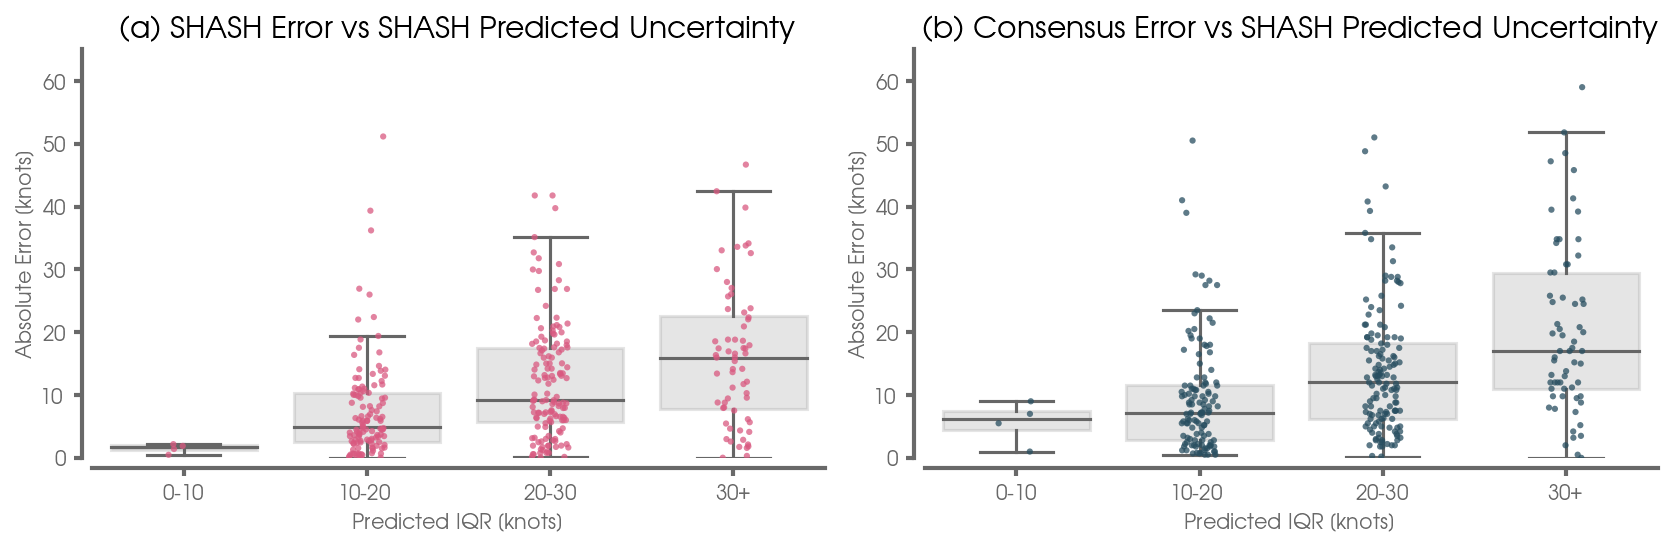

In [10]:
PLOT_DATA = '_valtest'
colors = ('#D95980','#284E60','#284E60','#C3B1E1','#351F27','#A9C961')
#------------------------------------------

if PLOT_DATA == '_valtest':
    x_eval = x_valtest
    onehot_eval = onehot_valtest
    df_eval = df_valtest
    pred_eval = pred_dict[exp_name][RNG_SEED]['pred_cpd' + PLOT_DATA]    
elif PLOT_DATA == '_test':
    x_eval = x_test
    onehot_eval = onehot_test
    df_eval = df_test    
    pred_eval = pred_dict[exp_name][RNG_SEED]['pred_cpd' + PLOT_DATA]    
else:
    raise NotImplementedError('no such PLOT_DATA')

imp.reload(analysis_plots)
f, axs = plt.subplots(1, 2, figsize=(15/2*2*.75,5*.75))

# plot sample
ax1 = axs[0]
plot_iqr_vs_error(ax1,model, x_eval, onehot_eval, df_eval, yvar="shash_error")
ax1.set_ylim(0,65)
ax1.set_yticks(np.arange(0,70,10),np.arange(0,70,10))
ax1.set_xticks((0,1,2,3))
ax1.set_xticklabels(['0-10','10-20','20-30','30+'])    
format_spines(ax1)

ax2 = axs[1]
plot_iqr_vs_error(ax2,model, x_eval, onehot_eval, df_eval, yvar="cons_error")
ax2.set_ylim(0,65)
ax2.set_yticks(np.arange(0,70,10),np.arange(0,70,10))
ax2.set_xticks((0,1,2,3))
ax2.set_xticklabels(['0-10','10-20','20-30','30+'])    
format_spines(ax2)

# # plot PITS
# ax = axs[0]
# analysis_plots.plot_pits(ax, x_eval, onehot_eval, model, pred_eval, None)
# plt.ylim(0,.2)
# plt.title('(a) PIT histogram comparison', fontsize=FS, color='k')
# format_spines(ax)

plt.tight_layout()
plt.savefig(FIGURE_PATH + 'error_iqr_' + model_name + '.png', dpi=dpiFig)    
plt.show()

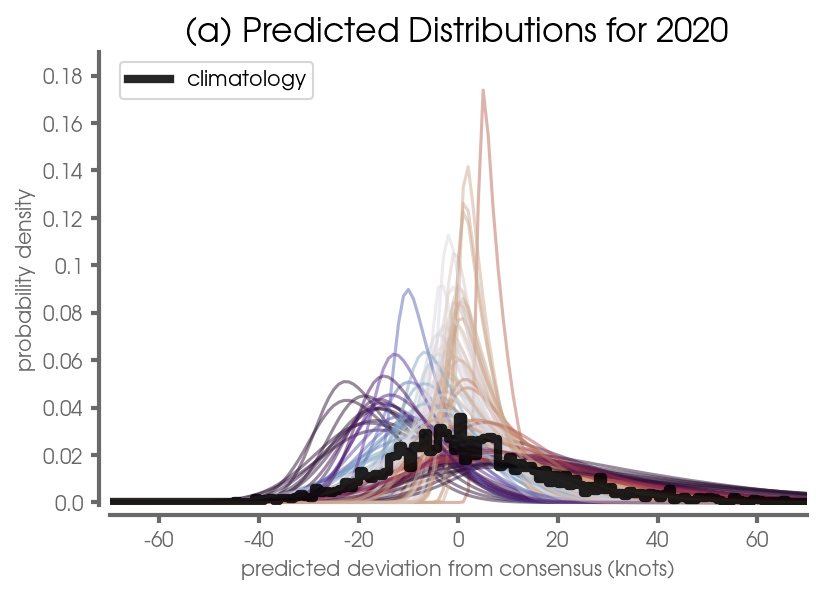

In [11]:
PLOT_DATA = '_test'
#------------------------------------------

if PLOT_DATA == '_valtest':
    x_eval = x_valtest
    onehot_eval = onehot_valtest
    df_eval = df_valtest
    pred_eval = pred_dict[exp_name][RNG_SEED]['pred_cpd' + PLOT_DATA]    
    pred_med_eval = pred_dict[exp_name][RNG_SEED]['pred_med' + PLOT_DATA]    
elif PLOT_DATA == '_test':
    x_eval = x_test
    onehot_eval = onehot_test
    df_eval = df_test    
    pred_eval = pred_dict[exp_name][RNG_SEED]['pred_cpd' + PLOT_DATA][::1] 
    pred_med_eval = pred_dict[exp_name][RNG_SEED]['pred_med' + PLOT_DATA][::1]   
else:
    raise NotImplementedError('no such PLOT_DATA')
    
#------------------------------------------    
obs_dev_cons_hist, OBS_DEV_BINS = model_diagnostics.compute_clim_errors(
    onehot=np.append(onehot_train[:,0],onehot_val[:,0]), 
    smooth = False,
)

#------------------------------------------    
N_COLORS = 50
cmap_interp = cm.get_cmap('twilight_shifted', N_COLORS)    
value_remap = np.linspace(-15, 15, N_COLORS)
norm = mpl.colors.Normalize(vmin=value_remap.min(), vmax=value_remap.max())
    
plt.figure()
for p in np.arange(0,pred_eval.shape[0]):
    
    plt.plot(SHASH_INCS, pred_eval[p,:], 
             linewidth=1.5,
             color=cmap_interp(norm(pred_med_eval[p])),
             alpha=.5,
            )
plt.step(OBS_DEV_BINS,
         obs_dev_cons_hist, 
         linewidth=4, 
         color='k',
         alpha=.85,
         label='climatology',
        )    
yticks = np.arange(0,.22,.02)    
plt.yticks(yticks,yticks)    
plt.ylim(-.001,.19)

plt.legend(loc=2)

xticks = np.arange(-100,120,20)
plt.xticks(xticks,xticks)    
plt.xlim(-70,70)

plt.xlabel('predicted deviation from consensus (knots)')
plt.ylabel('probability density')

plt.title('(a) Predicted Distributions for ' + str(settings["years_test"][0]), color='k', fontsize=FS)

ax = plt.gca()
format_spines(ax)

plt.savefig(FIGURE_PATH + 'predicted_distributions_' + model_name + '.png', dpi=dpiFig)    
plt.show()


## Plot examples

In [12]:
df_test[df_test["Name"]=='MARIE']

,ATCF,Name,year,time,ftime(hr),VMAX0,NCI,OBDV,DSDV,LGDV,...,EMDX,EGDX,HWDX,LONC,OBDY,AVDY,EMDY,EGDY,HWDY,LATC
3,EP18,MARIE,2020,100418,48,70.0,4,7.0,-12.0,-2.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
8,EP18,MARIE,2020,100106,48,80.0,4,11.0,12.0,4.0,...,-0.0,-49.2,-28.1,126.8,-70.4,-3.7,0.0,-3.7,7.4,18.2
11,EP18,MARIE,2020,100218,48,115.0,4,-6.8,-0.8,-8.8,...,-23.5,49.5,-13.0,129.4,0.0,11.1,-44.4,22.2,11.1,20.1
23,EP18,MARIE,2020,100206,48,115.0,4,4.8,3.8,-4.2,...,-28.8,33.9,-7.8,128.9,-33.3,44.4,-77.8,55.5,-22.2,19.8
26,EP18,MARIE,2020,100412,48,80.0,4,5.5,-10.5,-2.5,...,-105.0,89.5,-33.4,133.9,-88.9,-44.4,22.2,77.8,-55.5,22.7
28,EP18,MARIE,2020,100212,48,115.0,4,-2.0,0.0,-8.0,...,-41.8,10.4,10.5,129.3,-19.4,25.0,-63.9,69.4,-30.6,20.0
30,EP18,MARIE,2020,92918,48,35.0,4,9.5,12.5,3.5,...,-57.2,-0.0,50.1,120.3,-7.4,-7.4,48.1,0.0,-40.7,15.1
38,EP18,MARIE,2020,100100,48,65.0,4,11.0,11.0,3.0,...,5.3,-58.3,-37.1,125.9,-11.1,33.3,-66.7,44.4,-11.1,17.3
53,EP18,MARIE,2020,93012,48,50.0,4,16.0,6.0,3.0,...,-48.2,-90.7,26.7,124.2,30.6,30.6,-91.7,8.3,52.8,16.0
65,EP18,MARIE,2020,100300,48,115.0,4,-8.8,-1.8,-6.8,...,-41.7,31.2,-10.4,129.8,-25.0,41.7,-58.3,-2.8,19.4,20.6


-3.710801362991333 -6.0
-14.167598724365234 -24.799999237060547
3.5988292694091797 23.5
2.129068374633789 -20.5


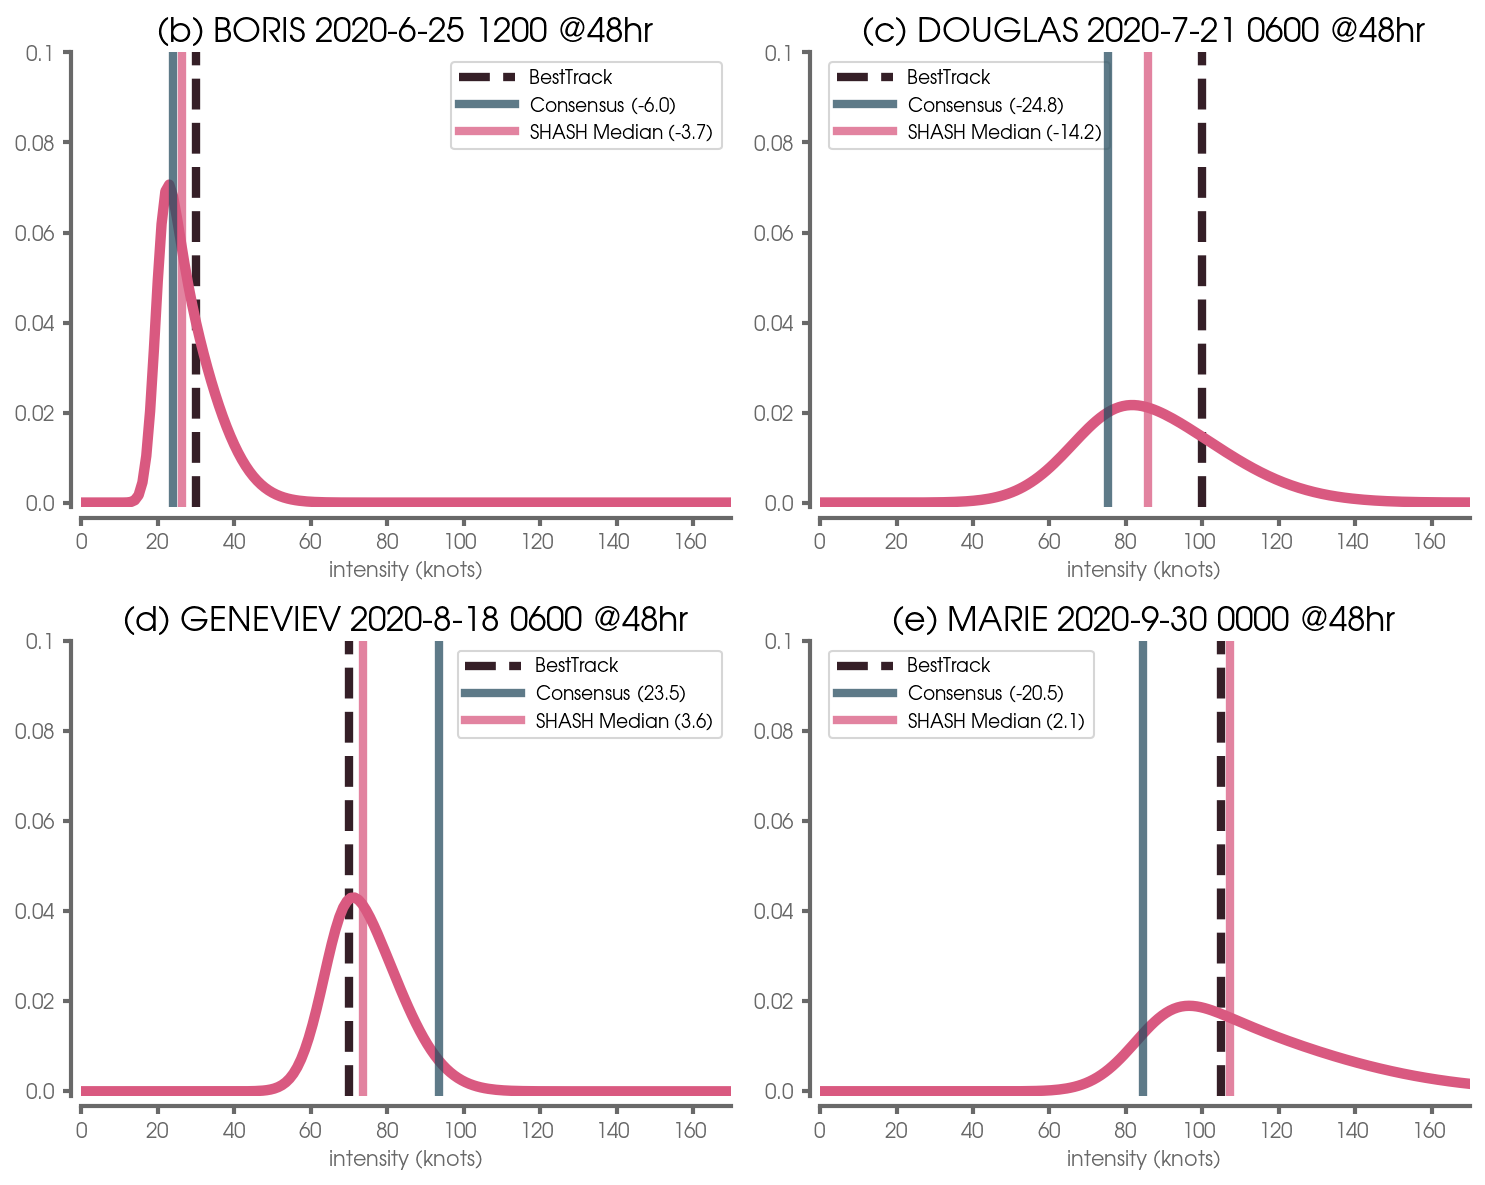

In [17]:
colors = ('#D95980','#284E60','#E1A730','#284E60','#C3B1E1','#351F27','#A9C961') 
# PLOTTING TESTING DATA ONLY
imp.reload(analysis_plots)
panel_letters = ('(b)','(c)','(d)','(e)')

f, axs = plt.subplots(2, 2, figsize=(10,8))
axs = axs.flatten()
random_samples = (19,20,75,83)#(19,20,75,83)

true_intensity = df_test["VMXC"] + df_test["OBDV"]
cons_intensity = df_test["VMXC"]

for isample, sample in enumerate(random_samples):
    
    cons_error = 0.0-onehot_test[sample,0]
    ann_error = pred_dict[exp_name][RNG_SEED]['pred_med_test'][sample]-onehot_test[sample,0]
    print(ann_error,cons_error )   
    
    ax = axs[isample]
    ax.axvline(x=true_intensity[sample],
               linestyle='--',               
               color=colors[-2],
               alpha=1.,
               linewidth=4,               
               label='BestTrack',
               zorder=0,               
              )
    
    ax.plot(SHASH_INCS+cons_intensity[sample],pred_dict[exp_name][RNG_SEED]['pred_cpd_test'][sample,:],
            color=colors[0],
            linewidth=5,
               zorder=5,            
            # clip_on=False,
           )
    ax.axvline(x=cons_intensity[sample],
               linestyle='-',               
               alpha=.75,
               linewidth=4,               
               color=colors[1],
               label='Consensus (' + str(cons_error.round(1)) + ')',
               zorder=50,
              )
    ax.axvline(x=pred_dict[exp_name][RNG_SEED]['pred_med_test'][sample]+cons_intensity[sample],
               linestyle='-',
               color=colors[0],
               linewidth=4,
               alpha=.75,
               label='SHASH Median (' + str(ann_error.round(1)) + ')',
               zorder=100,               
              )

    if isample==1 or isample==3:
        leg_loc = 2
    else:
        leg_loc = 1
    
    details = get_storm_details(df_test, sample)
    ax.set_title(panel_letters[isample] + ' ' + details, fontsize=FS, color='k')
    ax.legend(fontsize=9,handlelength=3,loc=leg_loc)
    ax.set_xlabel('intensity (knots)')
    ax.set_xticks(np.arange(0,180,20),np.arange(0,180,20))
    ax.set_yticks(np.arange(0,.16,.02),np.arange(0,.16,.02))    
    ax.set_xlim(0,170)
    ax.set_ylim(-.001,.1)
    format_spines(ax)
    
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'exampleDistributions_' + model_name + '.png', dpi=dpiFig)    
plt.show()   

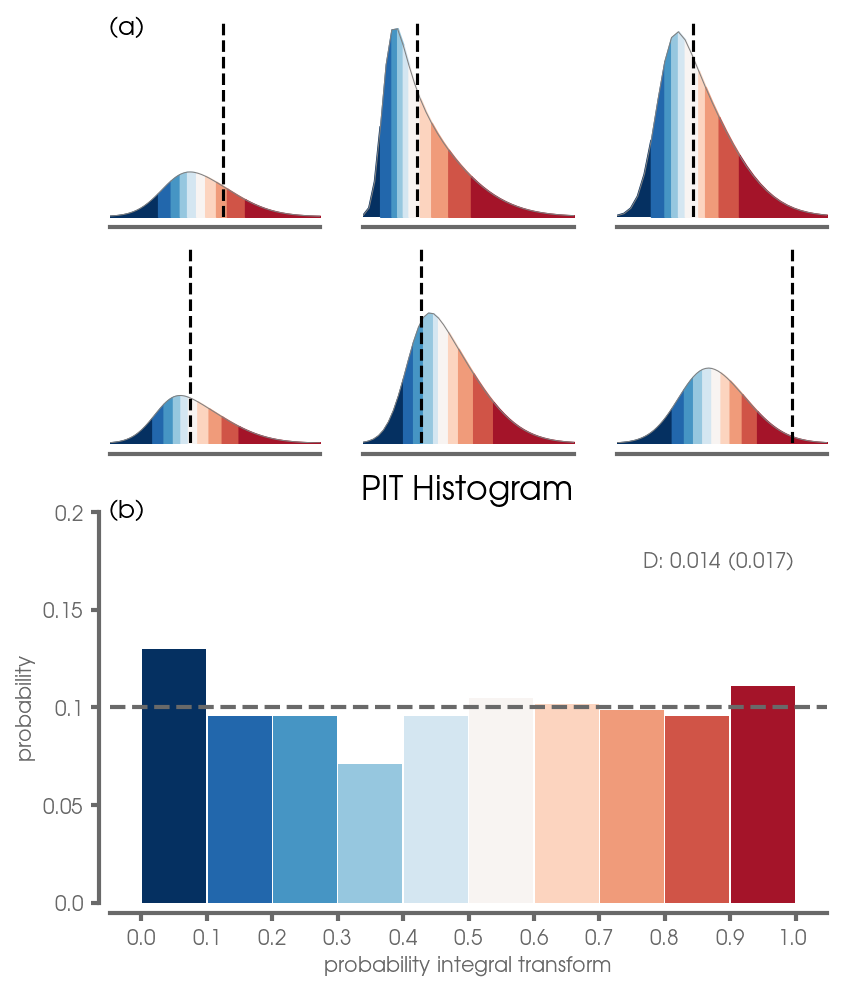

In [14]:

cmap_interp = cm.get_cmap('RdBu_r', N_COLORS)    
norm = mpl.colors.Normalize(vmin=0, vmax=10)

bins, hist_shash, D_shash, EDp_shash = model_diagnostics.compute_pit('shash',onehot_valtest, x_data=x_valtest,model_shash=model)
bins_inc = bins[1]-bins[0]

fig = plt.figure(figsize=(5.5, 6.5), constrained_layout=True)
spec = fig.add_gridspec(4, 3)

sample_count = 0
rng_plot = np.random.default_rng(12200)
plot_samples = rng_plot.choice(np.arange(0,onehot_test.shape[0]),size=6, replace=False)
    
for row in (0,1):
    for col in (0,1,2):
        
        ax = fig.add_subplot(spec[row,col])
        sample = plot_samples[sample_count]
        sample_count += 1        
        
        y = pred_dict[exp_name][RNG_SEED]['pred_cpd_test'][sample,:]
        ax.plot(SHASH_INCS,y,
                color='gray',
                linewidth=.5,
               )

        for iperc,perc in enumerate(np.arange(.10,1.10,.10)):
            cumsum = np.cumsum(y)
            ilow = np.argmin(np.abs(cumsum-(perc-.1)))
            ihigh = np.argmin(np.abs(cumsum-(perc)))        

            plt.fill_between(SHASH_INCS[ilow:ihigh+1],y[ilow:ihigh+1], color=cmap_interp(norm(iperc)))

        ax.axvline(x=onehot_test[sample,0],
                   linestyle='--',
                   color='k',
                   alpha=1.,
                   linewidth=1.5,
                  )
        
        ax.set_xlim(SHASH_INCS[np.argmin(np.abs(cumsum-.001))],SHASH_INCS[np.argmin(np.abs(cumsum-.999))])
        ax.set_ylim(0,.095)

        format_spines(ax)
        ax.set_xticks([], [])
        ax.set_yticks([], [])    
        ax.spines['left'].set_color(None)
        
        if(row==0 and col==0):  
            plt.text(np.min(ax.get_xlim()),.09*.99,
                     '(a)',
                     fontsize=12,
                     color='k',
                    )    

    
    
ax = fig.add_subplot(spec[2:,:])
for ibar in np.arange(0,len(bins)-1):
    plt.bar(bins[ibar]+bins_inc/2,
             hist_shash[0][ibar],
             width=bins_inc*.98,
             color=cmap_interp(norm(ibar)),
             label='SHASH',
            )

ax.axhline(y=.1, 
            linestyle='--',
            color='dimgray', 
            linewidth=2.,
           )
plt.ylim(0,.2)
plt.xticks(bins,np.around(bins,1))
ax = plt.gca()
yticks = np.around(np.arange(0,.25,.05),2)
plt.yticks(yticks,yticks)

plt.text(np.min(ax.get_xlim()),np.max(yticks)*.99,
         '(b)',
         fontsize=12,
         color='k',
        )

plt.text(1.,np.max(yticks)*.9,
         'D: ' + str(np.round(D_shash,4)) + ' (' + str(np.round(EDp_shash,3)) +  ')', 
         color='dimgray',     
         verticalalignment='top',
         horizontalalignment='right',
         fontsize=10)


plt.xlabel('probability integral transform')
plt.ylabel('probability')
plt.title('PIT Histogram', fontsize=FS, color='k')

format_spines(ax)
plt.savefig(FIGURE_PATH + 'example_pit_calculation_' + model_name + '.png', dpi=dpiFig)        


## Compute the probability of RI

In [15]:
if exp_name != 'intensity202_AL48' and settings["rng_seed"]!=416:
    raise ValueError('not plotting below, wrong experiment')

ValueError: not plotting below, wrong experiment

In [ ]:
metric_filename = PREDICTION_PATH + model_name + '_testingPredictions.csv'              
df_pred = pd.read_csv(metric_filename)
df_pred.keys()

In [ ]:
colors = ('#284E60','#D95980','#E1A730','#C3B1E1','#351F27','#A9C961')
#------------------------------------------------------------
true_vmx = df_pred["OBDV"]+df_pred["VMXC"]
i = np.where(true_vmx >= df_pred["VMAX0"]+RI_THRESH_DICT[settings['leadtime']])
ri_pred = df_pred.iloc[i]
# display(ri_pred[["Name","year","time","ftime(hr)","VMAX0","VMXC","shash_pr_ri","clim_pr_ri"]])

ri_pred_plot = ri_pred[["clim_pr_ri","shash_pr_ri"]].melt(var_name='prob_type', value_name='probability')

plt.figure()
ax = plt.gca()
sns.boxplot(x = "prob_type",
            y = "probability",
            data=ri_pred_plot,
            palette=colors,
            width=.75,
            dodge=False,
            boxprops={'alpha':.2,
                   # 'edgecolor': 'white',
                  },
            fliersize=0,
            ax=ax,
           )
sns.swarmplot(x = "prob_type",
            y = "probability",
            data=ri_pred_plot,
            palette=colors,
            dodge=False,
            size=7,
            ax=ax,
           )
yticks = np.around(np.arange(0,1.1,.1),2)
plt.yticks(yticks,yticks)
plt.xlabel(None)
plt.title(str(settings["leadtime"]) + 'hr Predicted Pr[RI] for True RI Events in ' + str(settings["years_test"][0]), fontsize=FS, color='k')
format_spines(ax)

plt.savefig(FIGURE_PATH + 'ri_probabilities_' + model_name + '.png', dpi=dpiFig)     
plt.show()


In [ ]:
colors = ('#284E60','#D95980','#E1A730','#C3B1E1','#351F27','#A9C961')
#------------------------------------------------------------
true_vmx = df_pred["OBDV"]+df_pred["VMXC"]
i = np.where(true_vmx < df_pred["VMAX0"]+RI_THRESH_DICT[settings['leadtime']])
ri_pred = df_pred.iloc[i]
# display(ri_pred[["Name","year","time","ftime(hr)","VMAX0","VMXC","shash_pr_ri","clim_pr_ri"]])

ri_pred_plot = ri_pred[["clim_pr_ri","shash_pr_ri"]].melt(var_name='prob_type', value_name='probability')

plt.figure()
ax = plt.gca()
sns.boxplot(x = "prob_type",
            y = "probability",
            data=ri_pred_plot,
            palette=colors,
            width=.75,
            dodge=False,
            boxprops={'alpha':.2,
                   # 'edgecolor': 'white',
                  },
            fliersize=0,
            ax=ax,
           )
sns.swarmplot(x = "prob_type",
            y = "probability",
            data=ri_pred_plot,
            palette=colors,
            dodge=False,
            size=2,
            alpha=.4,
            ax=ax,
           )
yticks = np.around(np.arange(0,1.2,.1),2)
plt.yticks(yticks,yticks)
plt.ylim(-.01,.5)
plt.xlabel(None)
plt.title(str(settings["leadtime"]) + 'hr Predicted Pr[RI] for No RI in ' + str(settings["years_test"][0]), fontsize=FS, color='k')
format_spines(ax)

plt.savefig(FIGURE_PATH + 'no_ri_probabilities_' + model_name + '.png', dpi=dpiFig)     
plt.show()


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10*.66,4),gridspec_kw={'width_ratios': [1]})

#=============================================================================
plt.subplot(1,1,1)

colors = ('#284E60','#D95980','#E1A730','#C3B1E1','#351F27','#A9C961')
cons_intensity = df_test["VMXC"]
vmx0 = df_test["VMAX0"]
true_vmx = df_pred["OBDV"]+df_pred["VMXC"]
i = np.where(true_vmx >= df_pred["VMAX0"]+RI_THRESH_DICT[settings['leadtime']])
ri_pred = df_pred.iloc[i]
sample = i[0][9]


obs_dev_cons_hist, OBS_DEV_BINS = model_diagnostics.compute_clim_errors(
    onehot=np.append(onehot_train[:,0],onehot_val[:,0]), 
    smooth = True,
)


x = SHASH_INCS + cons_intensity[sample]
y = pred_dict[exp_name][RNG_SEED]['pred_cpd_test'][sample,:]
x_clim = OBS_DEV_BINS + cons_intensity[sample]
y_clim = obs_dev_cons_hist

vmx_ri = vmx0[sample] + RI_THRESH_DICT[settings['leadtime']]
pr_ri = model_diagnostics.compute_pr_ri(x,y,vmx_ri)*100.
pr_clim_ri = model_diagnostics.compute_pr_ri(x_clim,y_clim,vmx_ri)*100.

plt.fill_between(x,y,y2=0,
                 where=x>=vmx_ri,
                 color=colors[1],
                 alpha=.3,
                )    

plt.axvline(x=true_intensity[sample],
           linestyle='--',               
           color=colors[-2],
           alpha=1.,
           linewidth=4,               
           label='BestTrack',
           zorder=0,               
          )   
print('Best Track = ' + str(true_intensity[sample]))

plt.plot(x,y, 
         color=colors[1],
         linewidth=3,
         label="SHASH",
        )


plt.axvline(x=vmx0[sample],
            color='gray',
            label='t=0',
            linestyle='-',   
            linewidth=3,
            alpha=.75,
           )
print('t=0 instensity = ' + str(vmx0[sample]))


plt.text(vmx_ri+8,0.0005,
         'Pr(RI)=' + str(int(pr_ri.round())) + '\%',
         color=colors[1],
         horizontalalignment='left',
         fontsize=16,
        )
plt.text(vmx0[sample]-3,.015,
         'intensity\nat t=0',
         color='gray',
         horizontalalignment='right',
         fontsize=10,
        )
plt.text(vmx0[sample]-3,.015,
         'intensity\nat t=0',
         color='gray',
         horizontalalignment='right',
         fontsize=10,
        )   
plt.text(160,.002,
         'SHASH',
         color=colors[1],
         horizontalalignment='left',
         fontsize=10,
        )   
plt.text(true_intensity[sample]+3,.019,
         'Best Track',
         color=colors[-2],
         horizontalalignment='left',
         fontsize=10,
        )      


details = get_storm_details(df_test, sample)
plt.title('(a) Rapid Intensification Probability\n' + details, fontsize=FS, color='k')

# plt.legend()
ax = plt.gca()
plt.xlim(0,190)
ax.set_xlabel('intensity (knots)')
ax.set_xticks(np.arange(0,210,20),np.arange(0,210,20))
ax.set_yticks(np.arange(0,.16,.01),np.arange(0,.16,.01))    
ax.set_xlim(0,190)
ax.set_ylim(-.0001,.024)
format_spines(ax)


#------------------------------------------------------------
# plt.subplot(1,2,2)
# colors = ('gray','#D95980','#E1A730','#C3B1E1','#351F27','#A9C961')
# true_vmx = df_pred["OBDV"]+df_pred["VMXC"]

# i = np.where(true_vmx >= df_pred["VMAX0"]+RI_THRESH_DICT[settings['leadtime']])
# ri_pred = df_pred.iloc[i]
# ri_pred_plot = ri_pred[["shash_pr_ri"]].melt(var_name='prob_type', value_name='probability')


# i = np.where(true_vmx < df_pred["VMAX0"]+RI_THRESH_DICT[settings['leadtime']])
# nori_pred = df_pred.iloc[i]
# nori_pred_plot = nori_pred[["shash_pr_ri"]].melt(var_name='prob_type', value_name='probability')
# nori_pred_plot["prob_type"] = 'shash_pr_nori'
# print(np.shape(nori_pred_plot))

# ri_plot_df = pd.concat([nori_pred_plot,ri_pred_plot])

# ax = plt.gca()
# sns.boxplot(x = "prob_type",
#             y = "probability",
#             data=ri_plot_df,
#             palette=colors,
#             width=.75,
#             dodge=False,
#             boxprops={'alpha':.2,
#                    # 'edgecolor': 'white',
#                   },
#             fliersize=0,
#             ax=ax,
#            )
# sns.swarmplot(x = "prob_type",
#             y = "probability",
#             data=ri_plot_df,
#             palette=colors,
#             dodge=True,
#             size=3,
#             alpha=.5,
#             ax=ax,
#            )

# yticks = np.around(np.arange(0,1.1,.1),2)
# plt.yticks(yticks,yticks)
# plt.xlabel(None)
# plt.xticks((0,1),('Not RI Event\nN=' + str(len(nori_pred_plot)),'RI Event\nN='+ str(len(ri_pred_plot))))
# plt.ylim(-.02,.7)
# # plt.title(str(settings["leadtime"]) + 'hr Predicted Pr[RI] for True RI Events in ' + str(settings["years_test"][0]), fontsize=FS, color='k')
# plt.title('(b) SHASH Predicted Pr[RI]\n ' + str(settings["years_test"][0]), fontsize=FS, color='k')
# format_spines(ax)

plt.tight_layout()
plt.savefig(FIGURE_PATH + 'ri_probability_caseStudy_boxwhisker_' + model_name + '.png', dpi=dpiFig)     
plt.show()


In [ ]:
# # Plot example from Marie
# df_marie = df_pred[df_pred["Name"]=="MICHAEL"]
# df_marie = df_marie.sort_values(by="time")

# fig, ax = plt.subplots()
# ax.plot(range(len(df_marie)),
#          df_marie["shash_pr_ri"],
#          '.-k',
#          color=colors[1],
#          label='SHASH3'
#         )
# ax.plot(range(len(df_marie)),
#          df_marie["clim_pr_ri"],
#          '.-',
#          color=colors[0],
#          label='Consensus'
#         )

# ax.legend()

# ax2 = ax.twinx()
# ax2.plot(range(len(df_marie)),
#          (df_marie["VMXC"]+df_marie["OBDV"]),
#          '.-',
#          color=colors[3],
#          label='VMAX at Verification'
#         )
# adjust_spines(ax, ['right', 'left', 'bottom'])
# ax.spines['top'].set_color('none')
# ax.spines['right'].set_color('dimgrey')
# ax.spines['left'].set_color('dimgrey')
# ax.spines['bottom'].set_color('dimgrey')
# ax.spines['right'].set_linewidth(2)
# ax.spines['left'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)
# ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
# ax2.tick_params('both',length=4,width=2,which='major',color='dimgrey')
# ax2.spines['top'].set_color(None)
# ax2.spines['bottom'].set_color(None)
# ax2.spines['left'].set_color(None)
# ax2.spines['right'].set_color(None)
# ax2.set_yticks(np.arange(0,200.,25),np.arange(0,200,25).round(1))    

# ax.set_xlabel('forecast time')
# ax.set_xticks((0,),(str(df_marie["time"].iloc[0]),))
# ax.set_yticks(np.arange(0,2.,.2),np.arange(0,2.,.2).round(1))    
# ax.set_xlim(-.5,len(df_marie))
# ax.set_ylim(-.015,1.)
# ax2.set_ylim(0,125)
# ax2.tick_params(axis='y', labelcolor=colors[3])
# ax2.set_ylabel('VMAX at Verification [kts]', color=colors[3])
# ax.set_ylabel('Pr[RI]')

# details = get_storm_details(df_marie, 0)
# ax.set_title('RI Event: MARIE @48hr', fontsize=FS, color='k')

# # plt.savefig(FIGURE_PATH + 'ri_timeseries_' + model_name + '_MARIE.png', dpi=dpiFig)  
# plt.show()